## Data Preprocessing

In [1]:
!pip install statsmodels

In [2]:
import os
import math
import requests
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

### Notebook Constants
DATA_PATH = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
COLUMNS = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
            'occupation', 'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country', 'salary'] # From archive description, fnlwgt will be ignored

In [3]:
req = requests.get(DATA_PATH)

csvreader = csv.reader(req.text, delimiter=",")

In [4]:
def dataToDict(dataText, rowdelimiter="\n", coldelimiter=", "):
    """
    Splits the rows for the data points by the rowdelimiter.
    Splits the column, row-wise
    """
    rows = dataText.split(rowdelimiter)[:-2] # Final two rows are blank
    return {i: data.split(coldelimiter) for i, data in enumerate(rows)}

In [5]:
customer_data = dataToDict(req.text)
customer_df = pd.DataFrame.from_dict(customer_data, orient='index', columns=COLUMNS)
customer_df = customer_df.drop("fnlwgt", axis=1)
for col in ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]: # Cast numerical columns to numerical data type
    customer_df[col] = pd.to_numeric(customer_df[col])

# Clean '?' Values
print(f"before\n {customer_df.isin(['?']).sum().sum()} values")
customer_df = customer_df.replace("?", "none")
print(f"after\n {customer_df.isin(['?']).sum().sum()} values")

before
 4262 values
after
 0 values


## Plotting Marital Status vs. Income

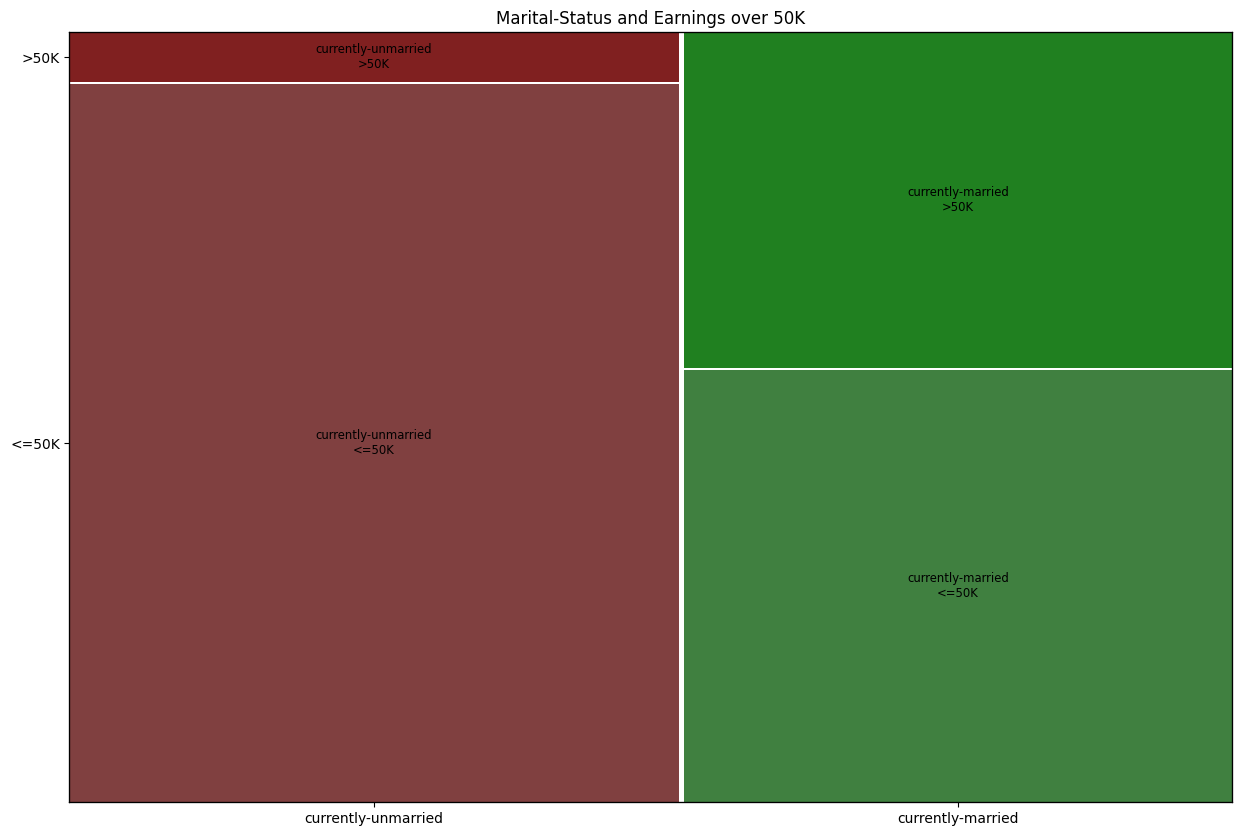

In [6]:
# Create a mosaic plot associating marital status to earning less than or greater than 50K
currently_married = ['Married-civ-spouse', 'Married-AF-spouse', 'Married-spouse-absent']
customer_df["binary-marital-status"] = customer_df["marital-status"].apply(lambda x: "currently-married" if x in currently_married else "currently-unmarried")
fig, ax = plt.subplots(figsize=(15, 10))
mosaic(customer_df, ["binary-marital-status", "salary"], title="Marital-Status and Earnings over 50K", ax=ax)
plt.show()

### Plotting Marital Status and Gender vs Income

<ipython-input-7-46b8b984f6e1>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(
<ipython-input-7-46b8b984f6e1>:11: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.catplot(


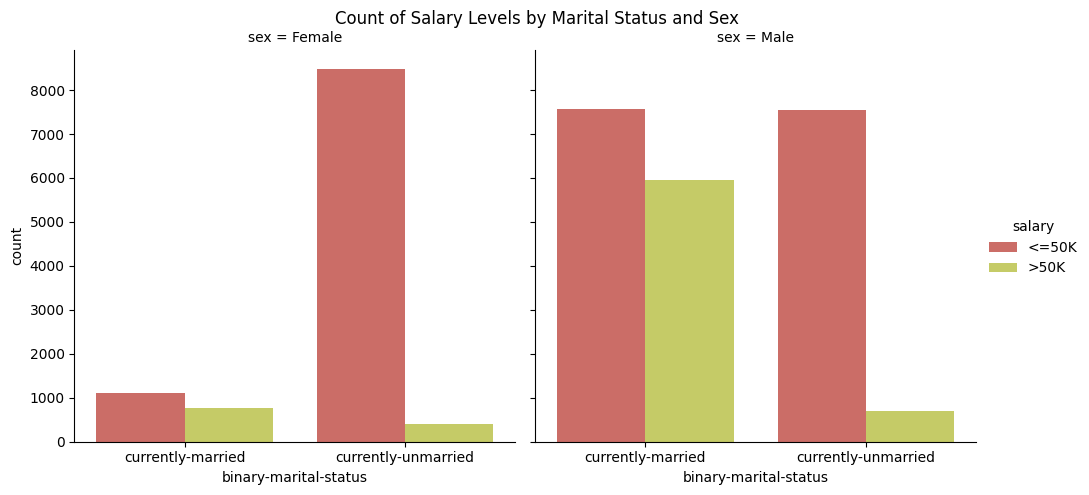

In [7]:
# Stacked Bar Chart
import seaborn as sns
temp = customer_df.groupby(['binary-marital-status', 'sex'])['salary'].value_counts().to_frame(name='count').reset_index()
# Calculate the total count for each group of binary-marital-status and sex
group_totals = temp.groupby(['binary-marital-status', 'sex'])['count'].transform('sum')

# Calculate the proportion of each count within its group
temp['proportion'] = temp['count'] / group_totals

# Grouped Bar Chart
sns.catplot(
    data=temp, kind="bar",
    x="binary-marital-status", y="count", hue="salary",
    col="sex", ci=None, height=5, aspect=1, palette=sns.color_palette("hls")
)
plt.subplots_adjust(top=0.9)
plt.suptitle('Count of Salary Levels by Marital Status and Sex')
plt.show()

### Plotting Marital Status vs. Income accounting for Age

<ipython-input-8-5c87132dd00d>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = customer_df.groupby(["age-bins", "binary-marital-status"])["salary"].value_counts().to_frame(name='count').reset_index()
<ipython-input-8-5c87132dd00d>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_totals = temp.groupby(['age-bins', 'binary-marital-status'])['count'].transform('sum')


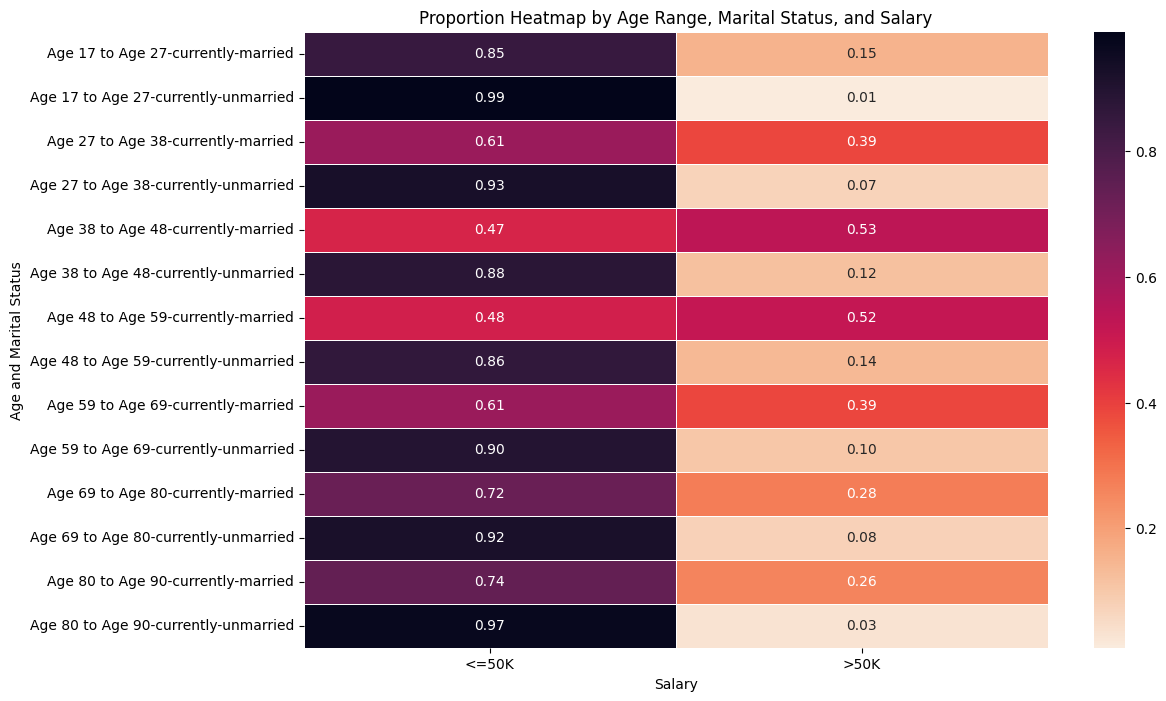

In [8]:
# Bin customer age data into 7 bins
customer_df["age-bins"] = pd.cut(customer_df["age"], 7)
# Create frame by aggregating salary count by age and marital status
temp = customer_df.groupby(["age-bins", "binary-marital-status"])["salary"].value_counts().to_frame(name='count').reset_index()
temp['age-bins'] = temp['age-bins'].apply(lambda x: f"Age {round(x.left)} to Age {round(x.right)}") # Pandas Interval object contains a left, and right
# Calculate the total count for each group of binary-marital-status and sex
group_totals = temp.groupby(['age-bins', 'binary-marital-status'])['count'].transform('sum')

# Calculate the proportion of each count within its group
temp['proportion'] = temp['count'] / group_totals

# Pivot the data to get it into a format suitable for a heatmap
heatmap_data = temp.pivot_table(index=['age-bins', 'binary-marital-status'], columns='salary', values='proportion', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='rocket_r', fmt='.2f', linewidths=.5)

# Set plot labels and title
plt.title('Proportion Heatmap by Age Range, Marital Status, and Salary')
plt.xlabel('Salary')
plt.ylabel('Age and Marital Status')

# Show the plot
plt.show()

## Plotting Occupation vs. Income

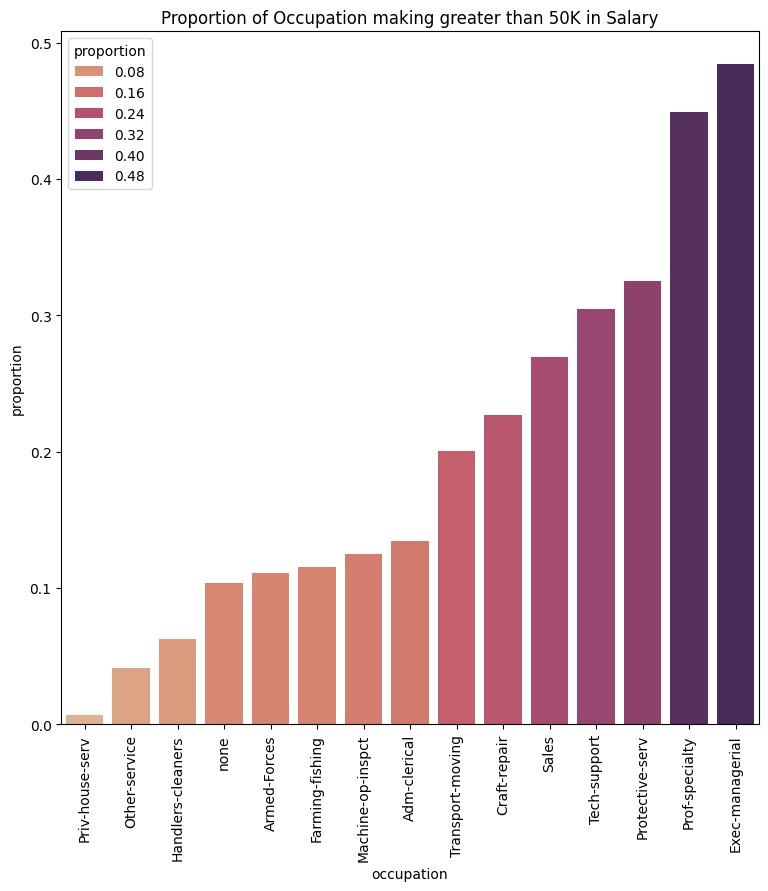

In [13]:
# Create frame by aggregating salary count by age and marital status
temp = customer_df.groupby(["occupation"])["salary"].value_counts().to_frame(name='count').reset_index()
# Calculate the total count for each group of binary-marital-status and sex
group_totals = temp.groupby(['occupation'])['count'].transform('sum')

# Calculate the proportion of each count within its group
temp['proportion'] = temp['count'] / group_totals

fig, ax = plt.subplots(figsize=(9, 9))
sns.barplot(temp[temp['salary'] == '>50K'].sort_values("proportion"), x='occupation', y='proportion', hue='proportion', palette='flare')
plt.xticks(rotation=90, ha='center')
plt.title("Proportion of Occupation making greater than 50K in Salary")
plt.show()

## Additional Multivariate Analysis

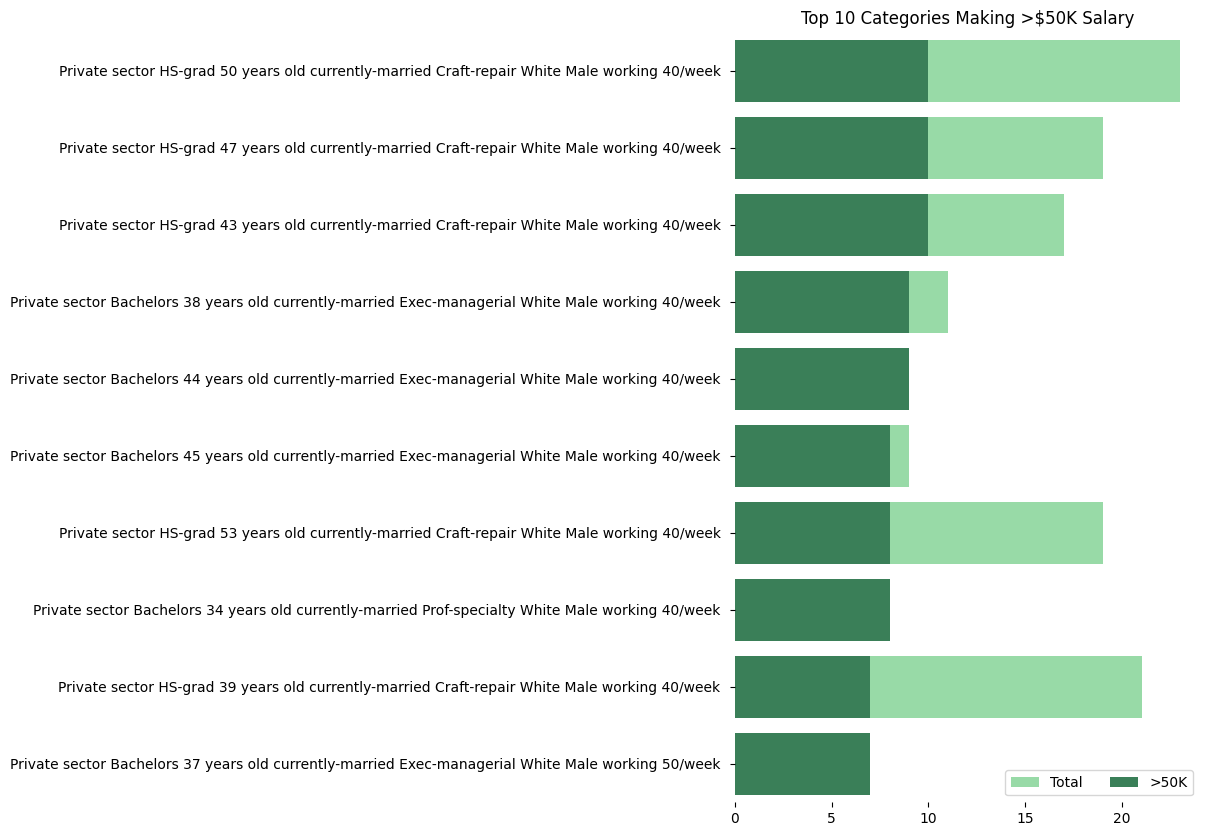

In [72]:
# Group by every category and find the most common descriptions for workers making over 50K
temp = customer_df.groupby(['workclass', 'education', 'education-num', 'binary-marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'age'])['salary'].value_counts().to_frame(name='count').reset_index()
temp['aggregated-desc'] = temp.apply(lambda x: x['workclass'] + ' sector ' + x['education'] + ' ' + str(x['age']) + ' years old ' + x['binary-marital-status'] + ' ' + x['occupation'] + ' ' + x['race'] + ' ' + x['sex'] + ' working ' + str(x['hours-per-week']) + '/week ', axis=1)
# Calculate the total count for each group of binary-marital-status and sex
temp['desc-total'] = temp.groupby(['aggregated-desc'])['count'].transform('sum')
temp = temp[temp['salary'] == ">50K"].sort_values('count', ascending=False).reset_index()

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 10))

# Plot the total
sns.set_color_codes("pastel")
sns.barplot(x="desc-total", y="aggregated-desc", data=temp[:10],
            label="Total", color="g")

# Plot the counts over 50K
sns.set_color_codes("muted")
sns.barplot(x="count", y="aggregated-desc", data=temp[:10],
            label=">50K", color="seagreen")

# Add a legend and informative axis label
plt.title("Top 10 Categories Making >$50K Salary")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, temp.loc[:, 'desc-total'].max()), ylabel="",
       xlabel="")
sns.despine(left=True, bottom=True)

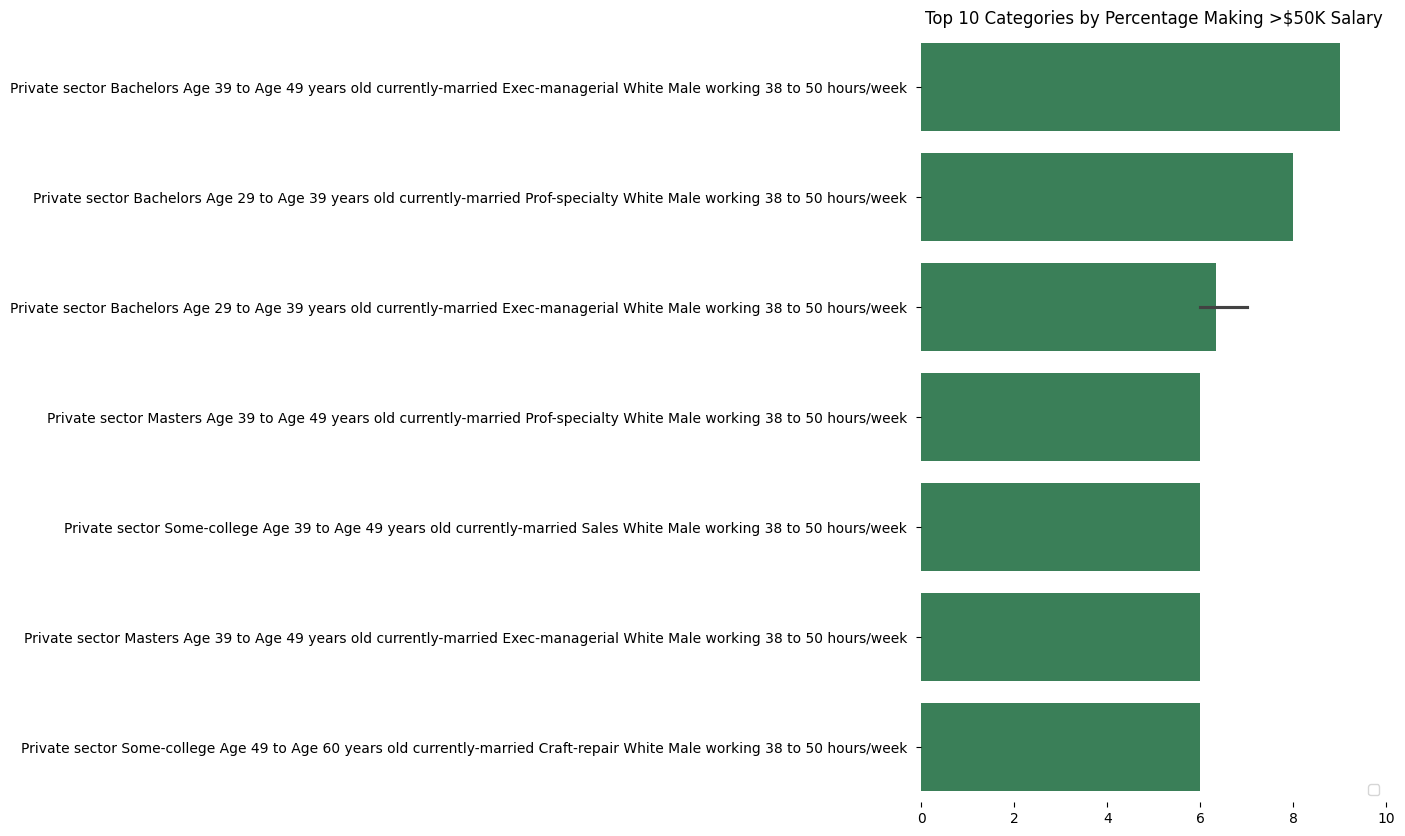

In [73]:
temp['proportion'] = temp['count'] / temp['desc-total']

# Many descriptions have a proportion of 1.0, so show the most common
temp = temp.sort_values(['proportion', 'count'], ascending=False) # sort by proportion rather than count

# Bin the age and hours-per-week to cast a wider net
temp['age'] = pd.cut(temp['age'], 7)
temp['hours-per-week'] = pd.cut(temp['hours-per-week'], 8)
temp['age'] = temp['age'].apply(lambda x: f"Age {round(x.left)} to Age {round(x.right)}") # Pandas Interval object contains a left, and right
temp['hours-per-week'] = temp['hours-per-week'].apply(lambda x: f"{round(x.left)} to {round(x.right)} hours")

# Compile the individuals description
temp['aggregated-desc'] = temp.apply(lambda x: x['workclass'] + ' sector ' + x['education'] + ' ' + str(x['age']) + ' years old ' + x['binary-marital-status'] + ' ' + x['occupation'] + ' ' + x['race'] + ' ' + x['sex'] + ' working ' + str(x['hours-per-week']) + '/week ', axis=1)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 10))
# Plot the counts over 50K
sns.set_color_codes("muted")
sns.barplot(x="count", y="aggregated-desc", data=temp[:10], color="seagreen")

# Add a legend and informative axis label
plt.title("Top 10 Categories with 100% Making >$50K Salary")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 10), ylabel="",
       xlabel="Count")
sns.despine(left=True, bottom=True)